## Fast CIFAR10 Training

Based on work by David C. Page: https://github.com/davidcpage/cifar10-fast

This implementation was built on work by Thomas Germer: https://github.com/99991/cifar10-fast-simple/

Also incorporates ideas from Fern: https://github.com/tysam-code/hlb-CIFAR10 and Jordan Keller: https://github.com/KellerJordan/cifar10-airbench/

The main focus of this implementation is to be readable for deep learning beginners, and use built-in pytorch functions as much as possible. 

#### Package Imports and Device Setup

In [1]:
# PyTorch imports
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn

# Torchvision imports
import torchvision
from torchvision import datasets
from torchvision.transforms import v2

# For timing training/testing loops
from timeit import default_timer as timer

# For visualisation of LR schedule curve
import matplotlib.pyplot as plt

In [2]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Precision for training speedup
dtype = torch.float16 if device.type != "cpu" else torch.float32

# Show package versions and hardware
print(f"PyTorch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}\n")
print(f"Device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(device.index)}\n")

PyTorch version: 2.1.0+cu118
Torchvision version: 0.16.0+cu118

Device: cuda
GPU: NVIDIA GeForce RTX 3090



#### Dataset Loading and Pre-processing

In [3]:
def preprocess_data(dataset, dtype=torch.float16, device="cuda"):
    """
    Change dataset datatype to dtype, then send to GPU.
    Calculate mean and std from dataset, then normalize.
    Permute data dimensions from NHWC to NCWH.
    Pad Training Images.
    """
    # Cast dataset data to tensor of dtype, place on GPU
    data = torch.from_numpy(dataset.data).to(dtype).to(device)

    # Normalize data
    # type and to might be redundant here
    mean = torch.mean(data, axis=(0, 1, 2))
    std = torch.std(data, axis=(0, 1, 2))
    data = (data - mean) / std

    # permute data NHWC to NCWH
    # See: https://discuss.pytorch.org/t/why-does-pytorch-prefer-using-nchw/83637/4
    data = data.permute(0, 3, 1, 2)

    # pad training images
    # functional.pad adds padding to 2 last dims of tensor, so perform after permute
    if dataset.train:
        data = v2.functional.pad(data, 4, padding_mode="reflect")

    return data


def load_data(data_path="data", dtype=torch.float16, device="cuda"):
    """
    Load CIFAR10 dataset.
    Preprocess train and Validation sets.
    """

    train = datasets.CIFAR10(root=data_path, train=True, download=True)
    test = datasets.CIFAR10(root=data_path, train=False, download=True)

    X_train = preprocess_data(train, dtype, device)
    X_test = preprocess_data(test, dtype, device)

    y_train = torch.tensor(train.targets).to(device)
    y_test = torch.tensor(test.targets).to(device)

    return X_train, y_train, X_test, y_test

In [4]:
## Load dataset
X_train, y_train, X_test, y_test = load_data()

100.0%


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


#### Network

In [5]:
## Patch-based PCA Whitening weights initialisation
# Implementation by Thomas Germer: https://github.com/99991/cifar10-fast-simple/
# Refer to Keller Jordan's paper for explanation:  https://arxiv.org/abs/2404.00498


def patch_whitening(data, patch_size=(3, 3)):
    # Compute weights from data such that
    # torch.std(F.conv2d(data, weights), dim=(2, 3))is close to 1.
    h, w = patch_size
    c = data.size(1)
    patches = data.unfold(2, h, 1).unfold(3, w, 1)
    patches = patches.transpose(1, 3).reshape(-1, c, h, w).to(torch.float32)

    n, c, h, w = patches.shape
    X = patches.reshape(n, c * h * w)
    X = X / (X.size(0) - 1) ** 0.5
    covariance = X.t() @ X

    eigenvalues, eigenvectors = torch.linalg.eigh(covariance)

    eigenvalues = eigenvalues.flip(0)

    eigenvectors = eigenvectors.t().reshape(c * h * w, c, h, w).flip(0)

    return eigenvectors / torch.sqrt(eigenvalues + 1e-2).view(-1, 1, 1, 1)

In [6]:
## Ghost BatchNorm
# Implementation by Thomas Germer: https://github.com/99991/cifar10-fast-simple/
# Designed by Hoffer, Hubara, Soudry: https://arxiv.org/abs/1705.08741


class GhostBatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)

        running_mean = torch.zeros(num_features * num_splits)
        running_var = torch.ones(num_features * num_splits)

        self.weight.requires_grad = False
        self.num_splits = num_splits
        self.register_buffer("running_mean", running_mean)
        self.register_buffer("running_var", running_var)

    def train(self, mode=True):
        if (self.training is True) and (mode is False):
            # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits
            )
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits
            )
        return super().train(mode)

    def forward(self, input):
        n, c, h, w = input.shape
        if self.training or not self.track_running_stats:
            assert (
                n % self.num_splits == 0
            ), f"Batch size ({n}) must be divisible by num_splits ({self.num_splits}) of GhostBatchNorm"
            return F.batch_norm(
                input.view(-1, c * self.num_splits, h, w),
                self.running_mean,
                self.running_var,
                self.weight.repeat(self.num_splits),
                self.bias.repeat(self.num_splits),
                True,
                self.momentum,
                self.eps,
            ).view(n, c, h, w)
        else:
            return F.batch_norm(
                input,
                self.running_mean[: self.num_features],
                self.running_var[: self.num_features],
                self.weight,
                self.bias,
                False,
                self.momentum,
                self.eps,
            )

In [7]:
## Fast CIFAR10 Resnet "Bag of Tricks" architecture by David C. Page
# http://web.archive.org/web/20201123223831/https://myrtle.ai/learn/how-to-train-your-resnet-8-bag-of-tricks/


class FastCIFAR_BoT(nn.Module):
    def __init__(
        self,
        first_layer_weights: torch.Tensor,
        celu_alpha: float,
        input_shape: int,
        hidden_units: int,
        output_shape: int,
        output_scale: float,
    ):
        super().__init__()

        ## First layer contains patch whitened initialised weights and is frozen.
        conv1_out_shape = first_layer_weights.size(0)
        conv1 = nn.Conv2d(in_channels=input_shape, out_channels=conv1_out_shape, kernel_size=3, padding=1, bias=False)
        conv1.weight.data = first_layer_weights
        conv1.weight.requires_grad = False

        self.conv1 = conv1

        # From here, modified original arch:
        # Added GhostBatchNorm, add CELU, Move max pool2d to second layer.
        # Prep layer
        self.prep = nn.Sequential(
            nn.Conv2d(in_channels=conv1_out_shape, out_channels=hidden_units, kernel_size=1, padding=0, bias=False),
            GhostBatchNorm(hidden_units, num_splits=16),
            nn.CELU(alpha=celu_alpha),
        )

        # Layer 1 with residual connections and 2 res sequences
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=(hidden_units * 2), kernel_size=3, padding=1, bias=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            GhostBatchNorm((hidden_units * 2), num_splits=16),
            nn.CELU(alpha=celu_alpha),
        )

        self.res1 = nn.Sequential(
            nn.Conv2d(
                in_channels=(hidden_units * 2), out_channels=(hidden_units * 2), kernel_size=3, padding=1, bias=False
            ),
            GhostBatchNorm((hidden_units * 2), num_splits=16),
            nn.CELU(alpha=0.3),
        )
        self.res2 = nn.Sequential(
            nn.Conv2d(
                in_channels=(hidden_units * 2), out_channels=(hidden_units * 2), kernel_size=3, padding=1, bias=False
            ),
            GhostBatchNorm((hidden_units * 2), num_splits=16),
            nn.CELU(alpha=celu_alpha),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=(hidden_units * 2), out_channels=(hidden_units * 4), kernel_size=3, padding=1, bias=False
            ),
            nn.MaxPool2d(kernel_size=2, stride=2),
            GhostBatchNorm(hidden_units * 4, num_splits=16),
            nn.CELU(alpha=celu_alpha),
        )

        # Setup of Layer 3 etc is the same as layer 1 etc.
        self.layer3 = nn.Sequential(
            nn.Conv2d(
                in_channels=(hidden_units * 4), out_channels=(hidden_units * 8), kernel_size=3, padding=1, bias=False
            ),
            nn.MaxPool2d(kernel_size=2, stride=2),
            GhostBatchNorm(hidden_units * 8, num_splits=16),
            nn.CELU(alpha=celu_alpha),
        )

        self.res3 = nn.Sequential(
            nn.Conv2d(
                in_channels=(hidden_units * 8), out_channels=(hidden_units * 8), kernel_size=3, padding=1, bias=False
            ),
            GhostBatchNorm(hidden_units * 8, num_splits=16),
            nn.CELU(alpha=celu_alpha),
        )
        self.res4 = nn.Sequential(
            nn.Conv2d(
                in_channels=(hidden_units * 8), out_channels=(hidden_units * 8), kernel_size=3, padding=1, bias=False
            ),
            GhostBatchNorm(hidden_units * 8, num_splits=16),
            nn.CELU(alpha=celu_alpha),
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Flatten(),
            nn.Linear(in_features=(hidden_units * 8), out_features=output_shape, bias=False),
        )

        # Scale parameter for final layer
        self.output_scale = output_scale

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.prep(x)
        x = self.layer1(x)
        x = x + self.res2(self.res1(x))  # Residual connection
        x = self.layer2(x)
        x = self.layer3(x)
        x = x + self.res4(self.res3(x))  # Residual connection
        x = self.classifier(x)
        x = torch.mul(x, self.output_scale)

        return x

In [8]:
## Initialise training and validation models

# initialise weights of first layer with patch-whitening.
first_layer_weights = patch_whitening(X_train[:, :, 4:-4, 4:-4])

# Initialise training model
model = FastCIFAR_BoT(
    first_layer_weights, celu_alpha=0.3, input_shape=3, hidden_units=64, output_shape=10, output_scale=0.125
)

# Set model weights to half precision (torch.float16) for faster training
model.to(dtype)

# Set BatchNorm layers back to single precision (better accuracy)
for module in model.modules():
    if isinstance(module, nn.BatchNorm2d):
        module.float()

# Upload model to GPU
model.to(device)

## Initialise validation model
# Receives Exponential Moving Average weight update every 5 batches
val_model = AveragedModel(model, multi_avg_fn=get_ema_multi_avg_fn(0.95))

#### Loss Function and Optimizer

In [9]:
## Parameters for Loss Function and Optimizer:
# Training length parameters
epochs = 10
batch_size = 512

# Loss function parameters:
label_smoothing = 0.2

# Optimizer parameters
bias_scaler = 64
lr_weights = 0.512 / batch_size  # apply linear scaling rule
lr_bias = 0.512 * bias_scaler / batch_size
wd_weights = 0.0005 * batch_size
wd_biases = 0.0005 * bias_scaler / batch_size
momentum = 0.9
nesterov = True

# LambdaLR Scheduler helper parameters for Page-like learning curve
linear_factor = 0.1
phase1 = 0.2
phase2 = 0.8
total_train_steps = epochs * int(50000 / batch_size)

In [10]:
## Initialise loss function
# Use label smoothing for regularization
loss_fn = nn.CrossEntropyLoss(label_smoothing=label_smoothing, reduction="none")

In [11]:
# Helper function for LambdaLR Learning Rate Scheduler
def lr_lambda_helper(linear_factor, phase1, phase2, total_train_steps):
    """
    Returns Lambda LR scheduling helper.
    Scales defined LR in 3 phases:
    Phase 1: Increasing LR for (p1*total_steps) steps, by factor 0 to 1.
    Phase 2: Decreasing LR for (p2*total_steps) steps, by factor 1 to linear_factor.
    Phase 3: Constant LR at scale linear_factor.
    """

    p1 = int(phase1 * total_train_steps)
    p2 = int(phase2 * total_train_steps)

    def helper(step):
        if step < p1:  # Phase 1
            return step / p1
        elif step < (p1 + p2):  # Phase 2
            return 1 - ((step - p1) * (1 - linear_factor) / p2)
        else:
            return linear_factor  # Phase 3: Constant LR

    return helper

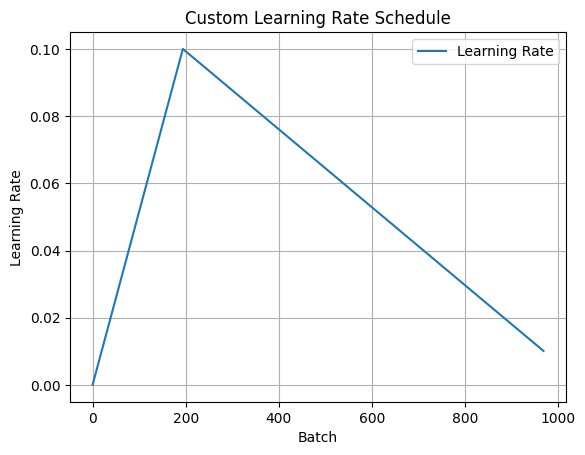

In [17]:
# Show Learning Rate Scaling curve:
import torch.optim as optim

lr_demo_optim = optim.SGD(torch.nn.Linear(10, 2).parameters(), lr=0.1)
lr_lambda = lr_lambda_helper(linear_factor, phase1, phase2, total_train_steps)
demo_sch = LambdaLR(lr_demo_optim, lr_lambda=lr_lambda)

lrs = []
for step in range(970):
    lrs.append(demo_sch.get_last_lr()[0])
    lr_demo_optim.step()
    demo_sch.step()

# Plot the learning rate schedule
plt.plot(range(970), lrs, label="Learning Rate")
plt.title("Custom Learning Rate Schedule")
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.legend()
plt.show()

In [13]:
## Initialise Optimizers and Learning Rate scheduler
# For separate updating of weights and biases:
weights = [par for name, par in model.named_parameters() if "weight" in name and par.requires_grad]
biases = [par for name, par in model.named_parameters() if "bias" in name and par.requires_grad]

# Initialise Stochastic Gradient Descent optimizers for weights and biases
optim_weight = SGD(params=weights, lr=lr_weights, weight_decay=wd_weights, momentum=momentum, nesterov=nesterov)
optim_bias = SGD(params=biases, lr=lr_bias, weight_decay=wd_biases, momentum=momentum, nesterov=nesterov)

# Learning rate schedules
lr_lambda = lr_lambda_helper(linear_factor, phase1, phase2, total_train_steps)
lr_sched_w = LambdaLR(optim_weight, lr_lambda=lr_lambda)
lr_sched_b = LambdaLR(optim_bias, lr_lambda=lr_lambda)

#### Training Loop

In [14]:
def train(seed=0):
    torch.manual_seed(seed)

    ## Training Loop inits
    batch_count = 0
    total_train_time = 0
    epochs = 10

    # Print stats:
    print("epoch    batch    train time [sec]    validation accuracy")
    print("---------------------------------------------------------")

    for epoch in range(1, epochs + 1):
        # Wait for all cuda streams on device to complete
        torch.cuda.synchronize()

        # Start epoch timer
        time_start_epoch = timer()

        ## Regularization transforms:
        # Alternating Flip (Jordan Keller); Can possibly speed up by avoiding torch.cat
        if epoch % 2:
            X_data = v2.functional.horizontal_flip(X_train[:25000])
            X_data = torch.cat((X_data, X_train[25000:]))
        else:
            X_data = v2.functional.horizontal_flip(X_train[25000:])
            X_data = torch.cat((X_train[:25000], X_data))

        # Random crop training images to 32x32
        X_data = v2.RandomCrop(size=(32, 32))(X_data)

        ## Randomly Erase 8x8 square from training image. Generally lowers validation accuracy.
        # X_data = v2.RandomErasing(p=0.5, scale=(0.25, 0.25), ratio=(1,1))(X_data)

        # Shuffle training data
        idx = torch.randperm(len(X_data), device=device)
        X_data = X_data[idx]
        y_data = y_train[idx]

        # Iterate over batches:
        for i in range(0, len(X_data), batch_size):
            # Discard partial batch (last batch is 336 images)
            if i + batch_size > len(X_data):
                break

            # select batch slice from training data
            X_batch = X_data[i : i + batch_size]
            y_true = y_data[i : i + batch_size]

            # Zero gradients before update, set model to train
            model.zero_grad()
            model.train(True)

            # Forward Pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_true)

            # Backward pass
            # Summed loss, refer Page
            loss.sum().backward()

            # Optimizer and LR step
            optim_weight.step()
            optim_bias.step()

            lr_sched_w.step()
            lr_sched_b.step()

            # update Validation model parameters with EMA every 5 batches
            if (i // batch_size % 5) == 0:
                val_model.update_parameters(model)

            batch_count += 1

        # Add epoch time to total
        total_train_time += timer() - time_start_epoch

        # Validation loop code taken directly from Thomas Germer
        val_correct = []
        for i in range(0, len(X_test), batch_size):
            val_model.train(False)

            # Test time augmentation; Follows Page, Germer
            regular_inputs = X_test[i : i + batch_size]
            flipped_inputs = torch.flip(regular_inputs, [-1])

            # val model logits
            logits1 = val_model(regular_inputs).detach()
            logits2 = val_model(flipped_inputs).detach()

            # Final logits are average of augmented logits
            logits = torch.mean(torch.stack([logits1, logits2], dim=0), dim=0)

            # Compute correct predictions
            correct = logits.max(dim=1)[1] == y_test[i : i + batch_size]

            val_correct.append(correct.detach().type(torch.float64))

        # Report validation accuracy
        val_acc = torch.mean(torch.cat(val_correct)).item()
        print(f"{epoch:5} {batch_count:8d} {total_train_time:19.2f} {val_acc:22.4f}")

#### Train 

In [15]:
# Run training for 10 epochs
train()

epoch    batch    train time [sec]    validation accuracy
---------------------------------------------------------
    1       97                3.67                 0.2270
    2      194                6.81                 0.4522
    3      291                9.97                 0.7243
    4      388               13.12                 0.8650
    5      485               16.27                 0.9027
    6      582               19.41                 0.9140
    7      679               22.57                 0.9227
    8      776               25.72                 0.9264
    9      873               28.87                 0.9249
   10      970               32.02                 0.9314
